In [1]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
from scipy.optimize import curve_fit
pplt.rc.reso='hi'
warnings.filterwarnings('ignore')

In [2]:
REGIONS   = {
    'Eastern Arabian Sea':{'latmin':9.,'latmax':19.5,'lonmin':64.,'lonmax':72.}, 
    'Central India':{'latmin':18.,'latmax':24.,'lonmin':76.,'lonmax':83.},
    'Central Bay of Bengal':{'latmin':9.,'latmax':14.5,'lonmin':86.5,'lonmax':90.},
    'Equatorial Indian Ocean':{'latmin':5.,'latmax':10.,'lonmin':62.,'lonmax':67.5},
    'Northwestern Coast':{'latmin':15.,'latmax':19.5,'lonmin':69.,'lonmax':72.5}} 
FILEDIR = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/data'
SAVEDIR = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/figs'
SAMPLETHRESH = 50

In [3]:
def open_dataset(filename,multi=False,filedir=FILEDIR):
    filepath = f'{filedir}/{filename}'
    if multi==True:
        ds = xr.open_mfdataset(filepath)
    else:
        ds = xr.open_dataset(filepath)
    return ds

ds1 = open_dataset('processed/binned_stats_new.nc')
ds2 = open_dataset('interim/OBS_bl-pr_*.nc',multi=True)

In [4]:
def interp_from_fit(xfit,yfit,x):
    f = get_fit(xfit,yfit)
    y = f(x.values.flatten())
    interped = xr.DataArray(y.reshape(x.shape),dims=x.dims,coords=x.coords)
    return interped

def get_fit(x,y):  
    x = x.flatten()
    y = y.flatten()
    mask = ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    def expfunc(x,a,b,c):
        return a*np.exp(b*x)+c
    params,_  = curve_fit(f=expfunc,xdata=x,ydata=y,maxfev=20000)
    a,b,c = params
    f = lambda x: a*np.exp(b*x)+c
    return f

def get_bin_mean_pr(stats,bintype,samplethresh=SAMPLETHRESH):
    if bintype=='1D':
        Q0 = stats.Q0.values
        Q1 = stats.Q1.values
        Q0[Q0==0.0] = np.nan
        Q = Q1/Q0
        Q[Q0<samplethresh] = np.nan
        return Q
    if bintype=='2D':
        P0 = stats.P0.values
        P1 = stats.P1.values
        P0[P0==0.0] = np.nan
        P = P1/P0
        P[P0<samplethresh] = np.nan
        return P

def get_region(data,key,regions=REGIONS):
    region = regions[key]
    return data.sel(lat=slice(region['latmin'],region['latmax']),lon=slice(region['lonmin'],region['lonmax']))

def get_month(data,month):
    return data.sel(time=data.time.dt.month==month)

def calc_monthly_mean(ds):
    return ds.groupby('time.month').mean('time').squeeze()

def calc_regional_mean(ds):
    return (ds*np.cos(np.deg2rad(ds.lat))).mean(dim=['lat','lon'])

In [5]:
regions       = []
realprlist    = []
predprindlist = []
predpralllist = []
for region in REGIONS:
    regions.append(region)
    region1 = ds1.sel(region=region)
    region2 = get_region(ds2,region)
    x = region1.bl.values
    y = get_bin_mean_pr(region1.sum(dim='month'),bintype='1D')
    predprall = interp_from_fit(x,y,region2.bl)
    region2 = region2.assign({'predprall':predprall})
    monthmeanlist = []
    for month in [6,7]:
        month1 = region1.sel(month=month)
        month2 = get_month(region2,month)
        x   = month1.bl.values
        y   = get_bin_mean_pr(month1,bintype='1D')
        predprind = interp_from_fit(x,y,month2.bl)
        month2 = month2.assign({'predprind':predprind})
        monthmean = calc_monthly_mean(month2)
        monthmeanlist.append(monthmean)        
    diff = (monthmeanlist[1]-monthmeanlist[0])
    realprlist.append(calc_regional_mean(diff.pr))
    predpralllist.append(calc_regional_mean(diff.predprall))
    predprindlist.append(calc_regional_mean(diff.predprind))

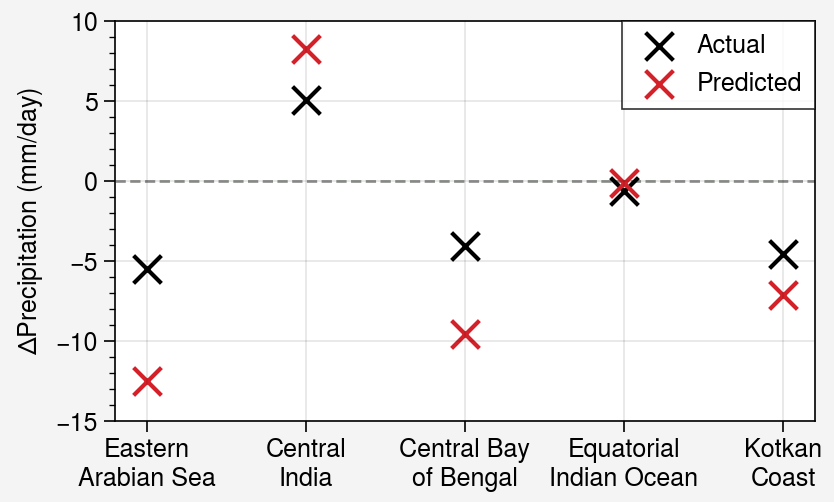

In [7]:
# pplt.rc['fontsize'] = 15
regions = ['Eastern\nArabian Sea','Central\nIndia','Central Bay\nof Bengal','Equatorial\nIndian Ocean','Kotkan\nCoast']
realpr = np.asarray(realprlist)
predpr = np.asarray(predprindlist)

fig,ax = pplt.subplots(refheight=2,refwidth=3.5)
ax.format(ylabel='$\Delta$Precipitation (mm/day)',ylim=(-15,10),yticks=5)
ax.axhline(y=0,color='grey',linestyle='--',linewidth=1,zorder=0)
ax.scatter(regions,realpr,color='k',marker='x',s=100,label='Actual')
ax.scatter(regions,predpr,color='#D42028',marker='x',s=100,label='Predicted')
ax.legend(loc='ur',ncols=1)
pplt.show()
fig.save(f'{SAVEDIR}/fig_4_poster.png',facecolor='#EEF7FC',dpi=900)

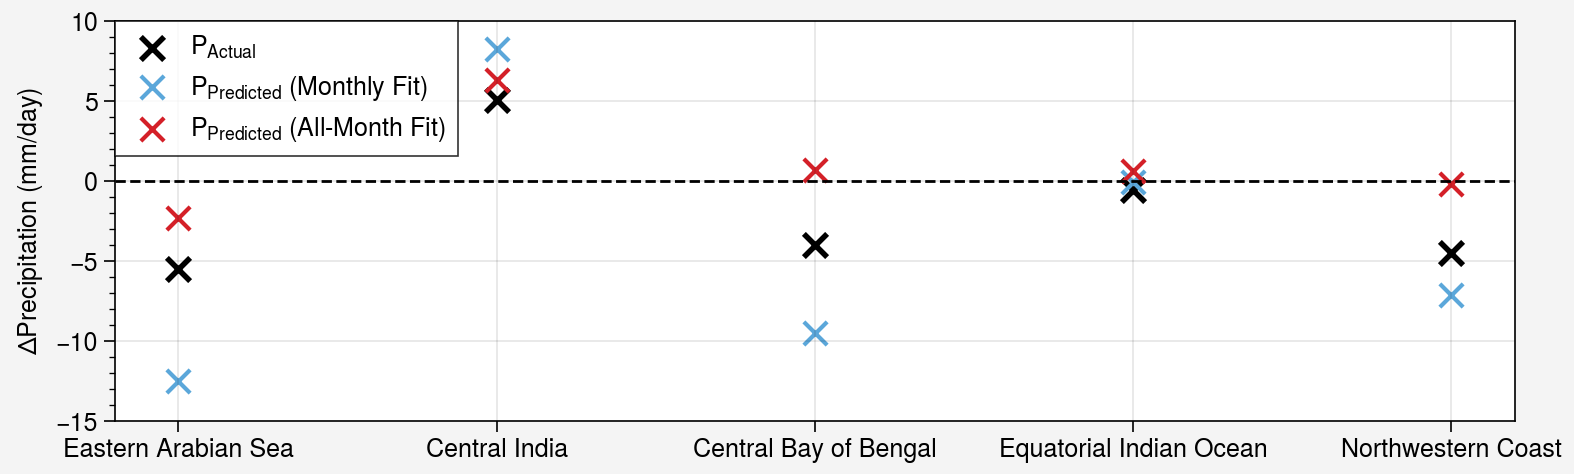

In [15]:
fig,ax = pplt.subplots(refheight=2,refwidth=7)
ax.format(ylabel='$\Delta$Precipitation (mm/day)',ylim=(-15,10),yticks=5)
ax.scatter(regions,realprlist,color='k',marker='x',s=70,linewidth=2,label='$P_{Actual}$')
ax.scatter(regions,predprindlist,color='#5BA7DA',marker='x',s=70,label='$P_{Predicted}$ (Monthly Fit)')
ax.scatter(regions,predpralllist,color='#D42028',marker='x',s=70,label='$P_{Predicted}$ (All-Month Fit)')
ax.axhline(y=0,color='k',linestyle='--',linewidth=1)
ax.legend(loc='ul',ncols=1)
pplt.show()
# fig.save(f'{SAVEDIR}/fig_4.png',dpi=300)